# **Baseline Model**

# **Model Choice**

For the baseline model, a **Convolutional Neural Network (CNN)** was used. CNNs are a widely adopted approach for image classification tasks due to their ability to automatically learn spatial hierarchies in the data. In this project, a simple CNN architecture was implemented to classify breast cancer images as **benign** or **malignant**.

In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import resample
from torch.utils.data import Dataset
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import roc_auc_score

In [2]:
# Set random seed for reproducibility
random_seed = 1
torch.backends.cudnn.enabled = False  # Disable CuDNN for deterministic behavior
torch.manual_seed(random_seed)  # Set manual seed for PyTorch


# **Feature Selection**

In [3]:
# Define dataset paths
root_dir = '/content/drive/MyDrive/Intermadiate_Machine_Learning/Final_project/training_set'
benign_dir = f'{root_dir}/benign'  # Path to benign images
malignant_dir = f'{root_dir}/malignant'  # Path to malignant images

In [4]:
# Function to create a dataset info dataframe
def create_dataset_info_dataframe(dataset_path):
    data = {'x_dim': [], 'y_dim': [], 'label': [], 'num_of_masks': [], 'path': []}

    # Loop through benign and malignant directories
    for label in ['benign', 'malignant']:
        class_dir = os.path.join(dataset_path, label)
        # Loop through files in the directory
        for file in os.listdir(class_dir):
            if file.endswith('.png') and not '_mask' in file:  # Check if the file is an image
                study_id = file.split('.')[0]  # Extract study ID
                img_path = os.path.join(class_dir, file)  # Full path to the image
                img = Image.open(img_path)  # Open the image
                x_dim, y_dim = img.size  # Get image dimensions
                # Count the number of masks for the study
                num_of_masks = sum(1 for f in os.listdir(class_dir) if f.startswith(study_id) and '_mask' in f)
                # Append data to the dictionary
                data['x_dim'].append(x_dim)
                data['y_dim'].append(y_dim)
                data['label'].append(label)
                data['num_of_masks'].append(num_of_masks)
                data['path'].append(img_path)

    return pd.DataFrame(data)  # Return the dataframe

In [5]:
# Load dataset into a dataframe
df = create_dataset_info_dataframe(root_dir)

# Split dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=random_seed, stratify=df['label'])

In [6]:
# Transformation pipeline
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to smaller dimensions
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

In [7]:
# Custom dataset class for breast cancer images
class BreastCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe  # Dataframe containing image paths and labels
        self.transform = transform  # Image transformations

    def __len__(self):
        return len(self.dataframe)  # Return the number of images in the dataset

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path']  # Get the image path
        img = Image.open(img_path).convert('RGB')  # Open and convert image to RGB

        if self.transform:
            img = self.transform(img)  # Apply transformations

        # Convert label to binary (1 for malignant, 0 for benign)
        label = 1 if self.dataframe.iloc[idx]['label'] == 'malignant' else 0
        return img, label  # Return the image and its label

In [8]:
# Create training and validation datasets and dataloaders
train_dataset = BreastCancerDataset(dataframe=train_df, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4)

val_dataset = BreastCancerDataset(dataframe=val_df, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# **Implementation**

In [9]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Define convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 3 input channels, 32 output channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 32 input channels, 64 output channels
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 64 input channels, 128 output channels
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # 128 input channels, 256 output channels

        # Define fully connected layers
        self.fc1 = nn.Linear(256 * 8 * 8, 512)  # Fully connected layer with 512 units
        self.fc2 = nn.Linear(512, 1)  # Output layer with 1 unit (binary classification)

    def forward(self, x):
        # Apply convolutional layers with ReLU and max pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)  # Max pooling with 2x2 window

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)

        # Flatten the tensor for fully connected layers
        x = x.view(x.size(0), -1)  # Flatten the tensor (batch_size, 256*8*8)

        x = F.relu(self.fc1(x))  # Apply ReLU activation
        x = self.fc2(x)  # Output layer (logits)

        return x  # Return the output logits


# **Evaluation**

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/15], Train Loss: 0.6638, Train ROC AUC: 0.7505, Val Loss: 0.6126, Val ROC AUC: 0.7071


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [2/15], Train Loss: 0.5735, Train ROC AUC: 0.8431, Val Loss: 0.5937, Val ROC AUC: 0.7580


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [3/15], Train Loss: 0.5879, Train ROC AUC: 0.5660, Val Loss: 0.7890, Val ROC AUC: 0.5829


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [4/15], Train Loss: 0.7074, Train ROC AUC: 0.6857, Val Loss: 0.6515, Val ROC AUC: 0.7492


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [5/15], Train Loss: 0.6328, Train ROC AUC: 0.5889, Val Loss: 0.6019, Val ROC AUC: 0.6266


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [6/15], Train Loss: 0.5880, Train ROC AUC: 0.7826, Val Loss: 0.6151, Val ROC AUC: 0.6927


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [7/15], Train Loss: 0.5872, Train ROC AUC: 0.8094, Val Loss: 0.5604, Val ROC AUC: 0.7003


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [8/15], Train Loss: 0.5456, Train ROC AUC: 0.8510, Val Loss: 0.5242, Val ROC AUC: 0.8237


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [9/15], Train Loss: 0.5080, Train ROC AUC: 0.8791, Val Loss: 0.4967, Val ROC AUC: 0.8353


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [10/15], Train Loss: 0.4065, Train ROC AUC: 0.9387, Val Loss: 0.5464, Val ROC AUC: 0.8582


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [11/15], Train Loss: 0.3311, Train ROC AUC: 0.8623, Val Loss: 0.5644, Val ROC AUC: 0.7744


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [12/15], Train Loss: 0.3090, Train ROC AUC: 0.9796, Val Loss: 0.6215, Val ROC AUC: 0.8365


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [13/15], Train Loss: 0.2013, Train ROC AUC: 0.9800, Val Loss: 0.5193, Val ROC AUC: 0.8614


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [14/15], Train Loss: 0.1651, Train ROC AUC: 0.9967, Val Loss: 0.8967, Val ROC AUC: 0.8714


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [15/15], Train Loss: 0.0925, Train ROC AUC: 0.9990, Val Loss: 0.8102, Val ROC AUC: 0.8454


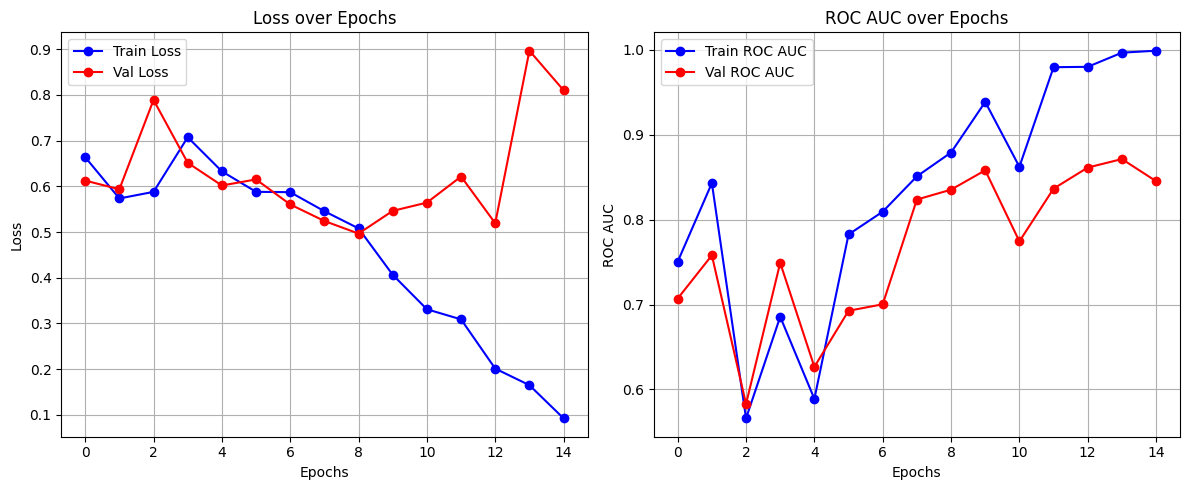

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Check if GPU is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Initialize the model and move it to the GPU
model = SimpleCNN().to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss with logits
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Helper function to calculate ROC AUC
def calculate_roc_auc(loader):
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():  # Disable gradient calculation
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(imgs)  # Forward pass
            probs = torch.sigmoid(outputs)  # Get predicted probabilities
            all_labels.extend(labels.cpu().numpy())  # Move labels back to CPU
            all_preds.extend(probs.cpu().numpy())  # Move predictions back to CPU

    # Calculate ROC AUC
    auc = roc_auc_score(all_labels, all_preds)
    return auc

# Lists to store loss and ROC AUC values
train_losses = []
val_losses = []
train_roc_aucs = []
val_roc_aucs = []

# Training loop
epochs = 15
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_train_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = model(imgs)

        # Ensure labels have the same shape as outputs
        labels = labels.view(-1, 1)  # Reshape labels to [batch_size, 1]

        # Calculate loss
        loss = criterion(outputs, labels.float())  # Apply loss function
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_train_loss += loss.item()  # Accumulate loss

    # Calculate average training loss for the epoch
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on the validation set
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(imgs)
            labels = labels.view(-1, 1)  # Reshape labels
            loss = criterion(outputs, labels.float())  # Apply loss function
            running_val_loss += loss.item()  # Accumulate validation loss

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Calculate ROC AUC for both train and validation sets
    train_roc_auc = calculate_roc_auc(train_loader)
    val_roc_auc = calculate_roc_auc(val_loader)

    train_roc_aucs.append(train_roc_auc)
    val_roc_aucs.append(val_roc_auc)

    # Print epoch info
    print(f'Epoch [{epoch+1}/{epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, Train ROC AUC: {train_roc_auc:.4f}, '
          f'Val Loss: {avg_val_loss:.4f}, Val ROC AUC: {val_roc_auc:.4f}')

# Plotting the training and validation loss/ROC AUC curves
plt.figure(figsize=(12, 5))

# Plotting Loss curves
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, marker='o', linestyle='-', color='b', label='Train Loss')
plt.plot(range(epochs), val_losses, marker='o', linestyle='-', color='r', label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting ROC AUC curves
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_roc_aucs, marker='o', linestyle='-', color='b', label='Train ROC AUC')
plt.plot(range(epochs), val_roc_aucs, marker='o', linestyle='-', color='r', label='Val ROC AUC')
plt.title('ROC AUC over Epochs')
plt.xlabel('Epochs')
plt.ylabel('ROC AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()